<a href="https://colab.research.google.com/github/sampad-singha/Alzheimer_Disease_Detection/blob/main/Sequential_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction + Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.17.1


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/datasets/kushagrasharma133/oasis-alzheimer-dataset) for our study.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/small_dataset/augmented_train_sample",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/small_dataset/augmented_train_sample",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5528 files belonging to 4 classes.
Using 4423 files for training.
Found 5528 files belonging to 4 classes.
Using 1105 files for validation.


In [ ]:
# class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# Visualize the data

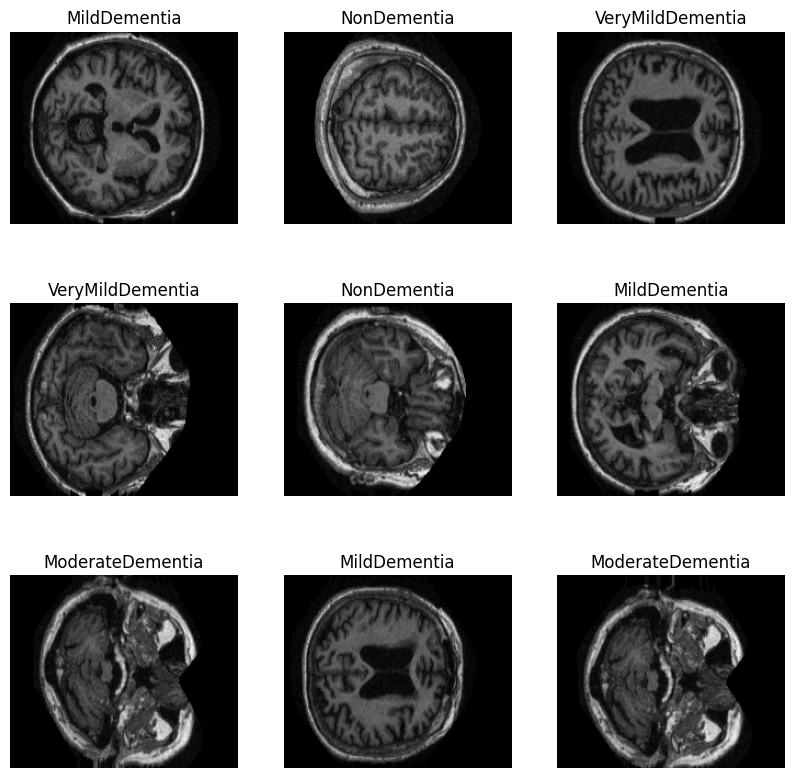

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Feature Engineering

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
# datasets = []
# for class_name in train_ds.class_names:
#     class_ds = train_ds.filter(lambda image, label: label == train_ds.class_names.index(class_name))
#     datasets.append(class_ds)

# balanced_ds = tf.data.experimental.sample_from_datasets(datasets, weights=[1/len(datasets)]*len(datasets))
# balanced_ds = balanced_ds.take(400)  # Take 400 batches from the balanced dataset

In [ ]:
# train_ds = train_ds.take(500)
# val_ds = val_ds.take(100)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = f"/content/drive/MyDrive/small_dataset/augmented_train_sample/{label}"
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, name))]))


In [ ]:
NUM_IMAGES

[1500, 1028, 1500, 1500]

# Build the CNN Model

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),

        # tf.keras.layers.Conv2D(16, 3, activation=None, padding='same'),
        # tf.keras.layers.LeakyReLU(negative_slope=0.01),
        # tf.keras.layers.Conv2D(16, 3, activation=None, padding='same'),
        # tf.keras.layers.LeakyReLU(negative_slope=0.01),

        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),

        dense_block(1024, 0.5), #this is new
        dense_block(512, 0.6), #this is new was 0.6
        dense_block(256, 0.5), #was 512,0.7
        dense_block(128, 0.2), #was 0.3
        dense_block(64, 0.2),  #was 0.3

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = ['accuracy', tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=5,
#     verbose=1
# )

# Model checkpoint callback (using `.keras` format)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "alzheimer_model.keras",
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 176, 208, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 176, 208, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 88, 104, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ (None, 44, 52, 32)          │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_20 (Sequential)           │ (None, 22, 26, 64)          │           7,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_21 (Sequential)           │ (None, 11, 13, 128)         │          27,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 11, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_22 (Sequential)           │ (None, 5, 6, 256)           │         103,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 5, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_23 (Sequential)           │ (None, 1024)                │       7,869,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_24 (Sequential)           │ (None, 512)                 │         526,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_25 (Sequential)           │ (None, 256)                 │         132,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_26 (Sequential)           │ (None, 128)                 │          33,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_27 (Sequential)           │ (None, 64)                  │           8,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,713,508 (33.24 MB)

 Trainable params: 8,708,580 (33.22 MB)

 Non-trainable params: 4,928 (19.25 KB)

## Fit model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.4127 - auc: 0.6823 - loss: 1.4790 - val_accuracy: 0.2760 - val_auc: 0.5480 - val_loss: 3.2148 - learning_rate: 0.0010
Epoch 2/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.5437 - auc: 0.8239 - loss: 0.9802 - val_accuracy: 0.2760 - val_auc: 0.5519 - val_loss: 6.3785 - learning_rate: 8.9125e-04
Epoch 3/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6090 - auc: 0.8673 - loss: 0.8507 - val_accuracy: 0.3955 - val_auc: 0.7149 - val_loss: 1.6641 - learning_rate: 7.9433e-04
Epoch 4/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6728 - auc: 0.9011 - loss: 0.7403 - val_accuracy: 0.4570 - val_auc: 0.7077 - val_loss: 3.0208 - learning_rate: 7.0795e-04
Epoch 5/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7035 - auc: 0.9189 - loss: 0.6666 - val_accuracy: 0.4000 - val_auc: 0.6855 - val_loss: 2.9161 - learning_rate: 6.3096e-04
Epoch 6/100
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/

# Visualize Model Metrics

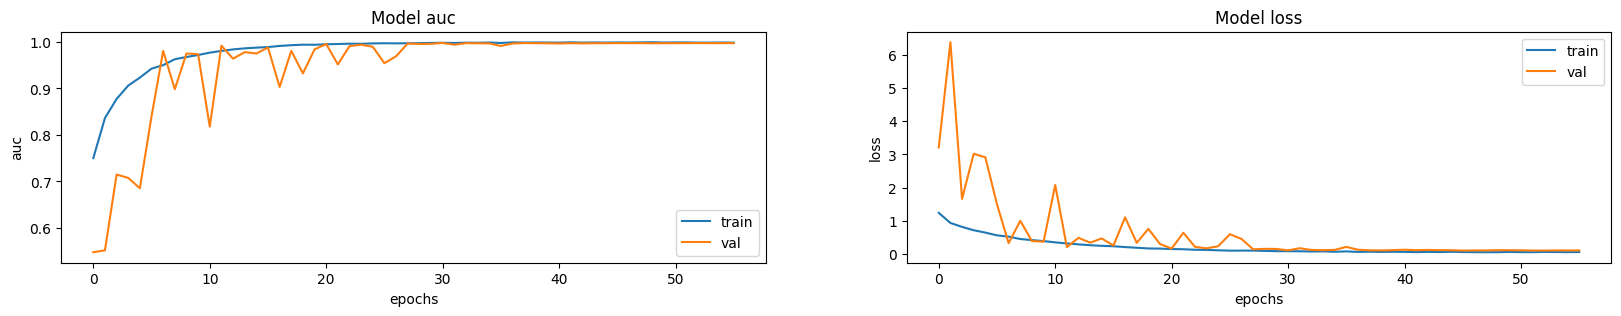

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

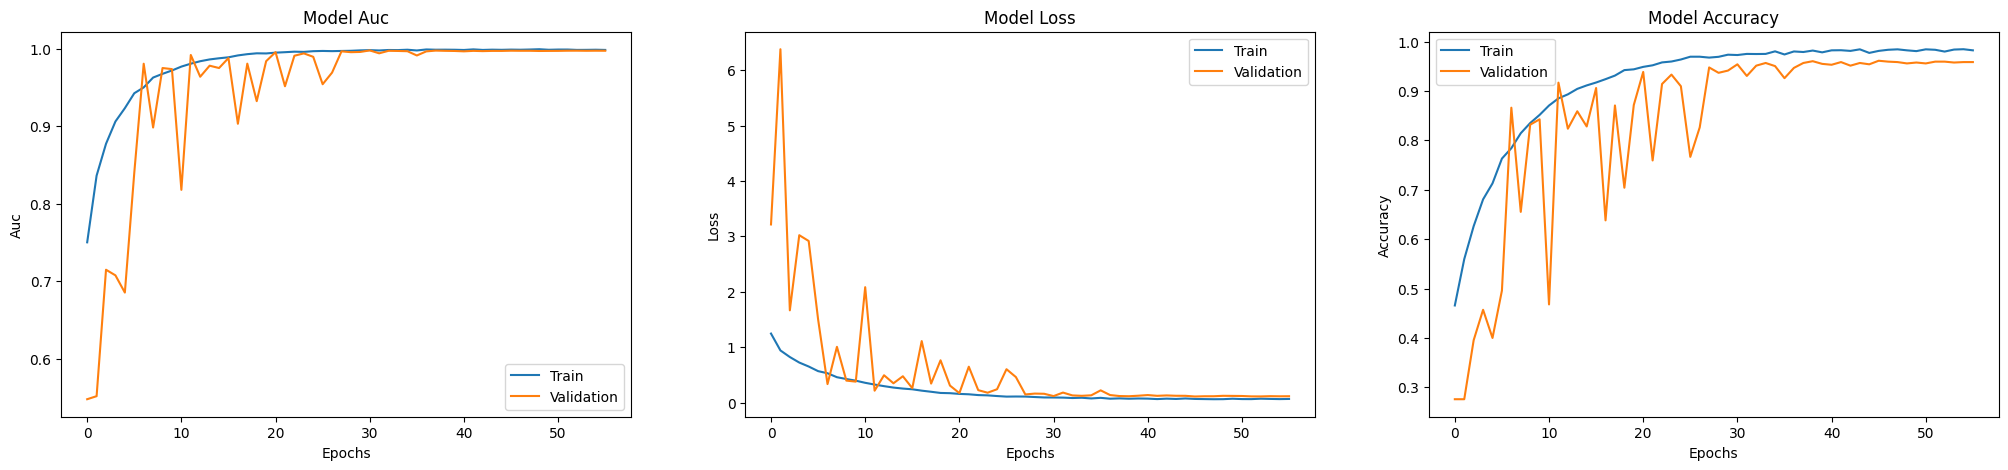

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))  # Adjusted to have 3 subplots
ax = ax.ravel()

# Plot for AUC
for i, met in enumerate(['auc', 'loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met.capitalize()))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend(['Train', 'Validation'])


# Evaluate the Model

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Sm_dataset/test_sample",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3457 files belonging to 4 classes.


In [ ]:
_ = model.evaluate(test_ds)

217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.9237 - auc: 0.9841 - loss: 0.2924


In [ ]:
import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted class indices

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

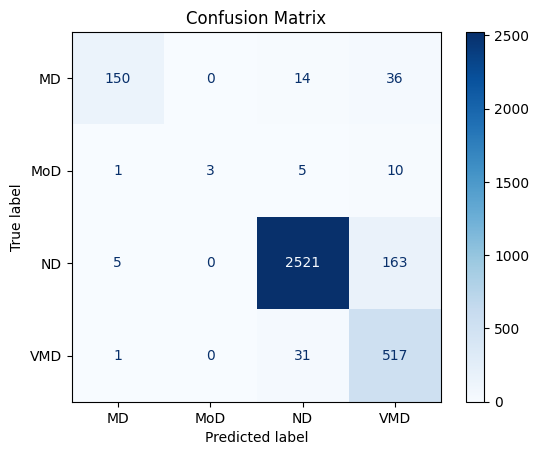

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_names  = ['MD', 'MoD', 'ND', 'VMD']
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Initialize TP, TN, FP, FN
TP = np.diag(cm)  # True Positives are the diagonal elements
FP = np.sum(cm, axis=0) - TP  # False Positives are column sums minus diagonal
FN = np.sum(cm, axis=1) - TP  # False Negatives are row sums minus diagonal
TN = np.sum(cm) - (TP + FP + FN)  # True Negatives are the total sum minus TP, FP, FN

# Initialize precision, recall, and F1-score
precision = TP / (TP + FP + 1e-10)  # Add a small value to avoid division by zero
recall = TP / (TP + FN + 1e-10)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

# Display results for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print()

# Display results for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1_score[i]:.4f}")
    print()


Class: MD
  TP: 150
  TN: 3250
  FP: 7
  FN: 50

Class: MoD
  TP: 3
  TN: 3438
  FP: 0
  FN: 16

Class: ND
  TP: 2521
  TN: 718
  FP: 50
  FN: 168

Class: VMD
  TP: 517
  TN: 2699
  FP: 209
  FN: 32

Class: MD
  Precision: 0.9554
  Recall: 0.7500
  F1-Score: 0.8403

Class: MoD
  Precision: 1.0000
  Recall: 0.1579
  F1-Score: 0.2727

Class: ND
  Precision: 0.9806
  Recall: 0.9375
  F1-Score: 0.9586

Class: VMD
  Precision: 0.7121
  Recall: 0.9417
  F1-Score: 0.8110



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def load_and_preprocess_image(image_path, target_size=(176, 208)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)  # Resize to target size
    return image

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/small_dataset/test_sample/Mild Dementia/OAS1_0031_MR1_mpr-3_106.jpg'  # Path to the image you want to predict
image = load_and_preprocess_image(image_path, target_size=(176, 208))  # Match model's input size
image_batch = np.expand_dims(image, axis=0)  # Add batch dimension

predictions = model.predict(image_batch)

# If your model has multiple classes, you will get an array of probabilities
predicted_class_index = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

predicted_class_label = class_names[predicted_class_index[0]]

# Display the predicted class
print(f'Predicted class: {predicted_class_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: MD


In [ ]:
model.save('/content/drive/MyDrive/Saved Models/Seq-itr-1-final.keras')